<a href="https://colab.research.google.com/github/AbdellrahmanAmgad/Head_Pose_Estimator_Dlib-Mediapipe/blob/main/MediaPipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing MediaPipe

In [1]:
%%capture
!pip install mediapipe

### Required Libraries

In [2]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe as mp
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from sklearn import svm
from sklearn.svm import SVC

### Dowlining Data

In [6]:
# link of the data
# http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

In [3]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

In [48]:
def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size = 60):
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

### Preparing Data

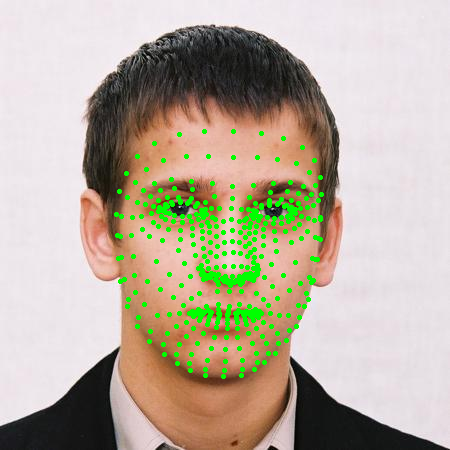

In [9]:
# choosing random image
random_file = 'image00053'
faceModule = mp.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      cv2_imshow(image)

In [49]:
def read_mat(path):
    # remove the .jpg extension
    path = path.split('.jpg')[0]
    # add the .mat extension
    path = path + '.mat'
    data = sio.loadmat(path)
    landmarks = data['pt3d_68']
    labels = data['Pose_Para'][0][:3]
    pitch, yaw, roll = labels
    return landmarks, pitch, yaw, roll

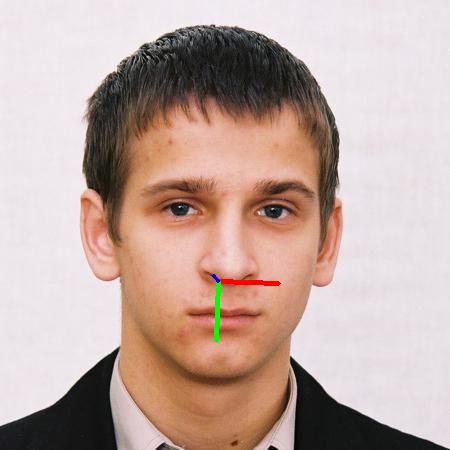

In [50]:
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
landmarks, pitch, yaw, roll = read_mat('/content/AFLW2000/'+random_file)
x,y = landmarks[0,32], landmarks[1,32]
cv2_imshow(draw_axis(image,pitch,-yaw,roll,x,y))

In [12]:
mylist2 = [Path(f).stem for f in glob.glob('/content/AFLW2000/*.jpg')]
print(mylist2)
print(len(mylist2))

['image01147', 'image01319', 'image00904', 'image00214', 'image02832', 'image04331', 'image02075', 'image04161', 'image00328', 'image01562', 'image02156', 'image02434', 'image04325', 'image00688', 'image01936', 'image03906', 'image00098', 'image03749', 'image03781', 'image03965', 'image03350', 'image03188', 'image02332', 'image02747', 'image03703', 'image02660', 'image00607', 'image03813', 'image00224', 'image03661', 'image00610', 'image01466', 'image01950', 'image02072', 'image02864', 'image00426', 'image00905', 'image00032', 'image01373', 'image00894', 'image02208', 'image03270', 'image00893', 'image00271', 'image01182', 'image01262', 'image00692', 'image00519', 'image03802', 'image02420', 'image03582', 'image00347', 'image01571', 'image00239', 'image01152', 'image03971', 'image02982', 'image00925', 'image01218', 'image02157', 'image02015', 'image03933', 'image01953', 'image03854', 'image00321', 'image02721', 'image03506', 'image00477', 'image02345', 'image00632', 'image00087', 'imag

In [13]:
x_Points= []
y_Points = []
labels = []
for img in mylist2:
  x_axis = []
  y_axis = []

  mat_file = sio.loadmat('/content/AFLW2000/'+img+'.mat')
  pose_para = mat_file["Pose_Para"][0][:3]
  pitch = pose_para[0]
  yaw = pose_para[1]
  roll = pose_para[2]

  labels.append([yaw, pitch, roll, img])
  faceModule = mp.solutions.face_mesh
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      # loading the image
      image = cv2.imread('/content/AFLW2000/'+img+'.jpg')
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                shape = image.shape 
                relative_x = np.array(int(x * shape[1]), dtype=np.int)
                relative_y = np.array(int(y * shape[0]), dtype=np.int)
                x_axis.append(relative_x)
                y_axis.append(relative_y)    
  x_Points.append(x_axis)
  y_Points.append(y_axis)

In [14]:
x_col = ['X{}'.format(i) for i in range(468)]
y_col = ['Y{}'.format(i) for i in range(468)]

In [15]:
df1=pd.DataFrame(x_Points,columns=x_col)
df1 =df1.astype(float)
df2=pd.DataFrame(y_Points,columns=y_col)
df2 =df2.astype(float)

labels_names= ['yaw', 'pitch', 'roll', 'image']
df3= pd.DataFrame(labels,columns=labels_names)
df4= pd.concat([df1,df2,df3],axis=1,join='inner')
df4

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,Y462,Y463,Y464,Y465,Y466,Y467,yaw,pitch,roll,image
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.168488,-0.177807,0.362510,image01147
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.255274,0.117057,0.002086,image01319
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.221054,0.024131,-0.038525,image00904
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.082943,-0.258793,-0.290036,image00214
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.903945,0.407710,-0.109906,image02832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,229.0,223.0,225.0,211.0,221.0,220.0,217.0,152.0,214.0,212.0,...,285.0,213.0,217.0,219.0,203.0,199.0,0.033398,-0.043316,-0.131604,image02824
1996,204.0,203.0,209.0,209.0,204.0,209.0,223.0,192.0,231.0,233.0,...,278.0,234.0,235.0,236.0,242.0,239.0,0.454686,-0.135370,0.143697,image04043
1997,235.0,243.0,236.0,232.0,243.0,241.0,233.0,177.0,230.0,230.0,...,279.0,227.0,230.0,232.0,220.0,218.0,-0.332142,-0.155669,-0.012203,image03407
1998,226.0,214.0,221.0,206.0,212.0,211.0,213.0,166.0,211.0,209.0,...,285.0,220.0,223.0,225.0,207.0,203.0,0.334741,-0.107574,-0.166388,image03551


In [16]:
df4=df4.dropna()
df4

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,Y462,Y463,Y464,Y465,Y466,Y467,yaw,pitch,roll,image
5,209.0,199.0,210.0,203.0,199.0,202.0,214.0,193.0,217.0,216.0,...,266.0,226.0,228.0,229.0,220.0,215.0,0.793277,0.215122,-0.027739,image04331
6,217.0,203.0,215.0,202.0,200.0,202.0,209.0,194.0,208.0,205.0,...,287.0,236.0,239.0,241.0,227.0,223.0,0.740965,-0.358170,-0.208181,image02075
8,226.0,231.0,228.0,224.0,232.0,232.0,232.0,161.0,233.0,234.0,...,287.0,217.0,220.0,222.0,211.0,210.0,-0.085357,-0.252363,0.042692,image00328
9,274.0,282.0,267.0,259.0,281.0,273.0,248.0,185.0,238.0,236.0,...,248.0,200.0,203.0,204.0,194.0,191.0,-1.070443,0.224836,-0.238284,image01562
11,216.0,202.0,214.0,198.0,200.0,201.0,206.0,170.0,205.0,202.0,...,287.0,217.0,220.0,223.0,204.0,198.0,0.447957,-0.256642,-0.202905,image02434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,229.0,223.0,225.0,211.0,221.0,220.0,217.0,152.0,214.0,212.0,...,285.0,213.0,217.0,219.0,203.0,199.0,0.033398,-0.043316,-0.131604,image02824
1996,204.0,203.0,209.0,209.0,204.0,209.0,223.0,192.0,231.0,233.0,...,278.0,234.0,235.0,236.0,242.0,239.0,0.454686,-0.135370,0.143697,image04043
1997,235.0,243.0,236.0,232.0,243.0,241.0,233.0,177.0,230.0,230.0,...,279.0,227.0,230.0,232.0,220.0,218.0,-0.332142,-0.155669,-0.012203,image03407
1998,226.0,214.0,221.0,206.0,212.0,211.0,213.0,166.0,211.0,209.0,...,285.0,220.0,223.0,225.0,207.0,203.0,0.334741,-0.107574,-0.166388,image03551


In [17]:
X = df4.drop(['yaw', 'pitch', 'roll','image'], axis=1)
yaw = df4['yaw']
pitch = df4['pitch']
roll = df4['roll']

X_train_yaw, X_test_yaw, y_train_yaw, y_test_yaw = train_test_split(X,yaw,test_size=0.2,random_state=42,shuffle=True)

X_train_pitch, X_test_pitch, y_train_pitch, y_test_pitch = train_test_split(X,pitch,test_size=0.1,random_state=0,shuffle=True)

X_train_roll, X_test_roll, y_train_roll, y_test_roll = train_test_split(X,roll,test_size=0.1,random_state=0,shuffle=True)

In [18]:
#good full code  edit here zabt dah
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import Normalizer

model_yaw = make_pipeline(MaxAbsScaler(),svm.SVR(C=15,epsilon=0.1)).fit(X_train_yaw, y_train_yaw)

model_pitch = make_pipeline(Normalizer(),svm.SVR(C=1.2,epsilon=0.05)).fit(X_train_pitch, y_train_pitch)

model_roll = make_pipeline(Normalizer(),svm.SVR(C=15,epsilon=0.1)).fit(X_train_roll, y_train_roll)

y_pred_yaw = model_yaw.predict(X_test_yaw)
y_pred_pitch = model_pitch.predict(X_test_pitch)
y_pred_roll = model_roll.predict(X_test_roll)

print("yaw = ",r2_score(y_test_yaw, y_pred_yaw)*100,"%")
print("pitch = ",r2_score(y_test_pitch, y_pred_pitch)*100,"%")
print("roll = ",r2_score(y_test_roll, y_pred_roll)*100,"%")

yaw =  89.33909811973231 %
pitch =  70.65973068470468 %
roll =  88.14622255533833 %


In [51]:
def show_image(path):
    capture = cv2.VideoCapture(path)
    ret, frame = capture.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # convert to RGB format for matplotlib
    landmarks, pitch, yaw, roll = read_mat(path)

    x,y = landmarks[0,32], landmarks[1,32]
    plt.imshow(draw_axis(frame, yaw, pitch, roll, x, y))
    plt.show()

    capture.release()
    cv2.destroyAllWindows()

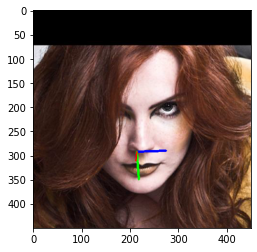

In [54]:
path = '/content/AFLW2000/image00419.jpg'
show_image(path)

In [58]:
capture = cv2.VideoCapture('/content/AFLW2000/image00419.jpg')
while capture.isOpened():
    ret, frame = capture.read()
    frame = cv2.resize(frame, (480,480))
    image_scale = frame.shape
    with faceModule.FaceMesh(static_image_mode=False) as faces:
        results = faces.process(frame)
        if results.multi_face_landmarks != None:
            landmarks = results.multi_face_landmarks[0]
            landmarks = np.array(landmarks)
            for landmarks_cords in landmarks:
                continue
            x,y = landmarks[0,32], landmarks[1,32]
        landmarks_ = landmarks[:2,:].reshape(1,-1)

        pitch_pred = model_yaw.predict(landmarks_)
        yaw_pred = model_pitch.predict(landmarks_)
        roll_pred = model_roll.predict(landmarks_)
        
        cv2.putText(frame, 'Pitch: ' + str(pitch_pred[0]), (0,20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
        cv2.putText(frame, 'Yaw: ' + str(yaw_pred[0]), (0,40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
        cv2.putText(frame, 'Roll: ' + str(roll_pred[0]), (0,60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
        cv2.imshow("Image", draw_axis(frame, yaw_pred, pitch_pred, roll_pred,x,y))
        if cv2.waitKey(5) & 0xFF == 27:
            break

TypeError: ignored

In [57]:
# plot predicted values
capture = cv2.VideoCapture(0)
ret, frame = capture.read()
#frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
nose_x, nose_y = landmarks[0,4], landmarks[1,4]
plt.imshow(draw_axis(frame, yaw_pred, pitch_pred, roll_pred, nose_x, nose_y))
plt.show()

NameError: ignored

In [ ]:
def show_image_2(path,path2):
    capture = cv2.VideoCapture(path)
    ret, frame = capture.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # convert to RGB format for matplotlib
    landmarks= read_mat(path2)

    xxx = np.array(landmarks)
    x0 = xxx[0][0]
    y0 = xxx[0][1]
    
    test = []
    for i in range(len(x0)):
        test.append(x0[i])
        test.append(y0[i])

    test = np.array(test).reshape(1,-1)
    xx = np.array(points_x_y_2[-1]).reshape(1,-1)

    y_pred_yaw = model_yaw.predict(xx)
    y_pred_pitch = model_pitch.predict(xx)
    y_pred_roll = model_roll.predict(xx)

    x, y = x0[32], y0[32]
    plt.imshow(draw_axis_1(frame, y_pred_yaw, y_pred_pitch,y_pred_roll, x, y))
    plt.show()
    capture.release()
    cv2.destroyAllWindows()